In [1]:
import keras
import pandas as pd
import os
import cv2
import scipy
import pickle
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from IPython.display import clear_output
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import randint
from sklearn.utils import shuffle


Using TensorFlow backend.


In [2]:
#import data

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\X_test.pickle", "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\y_test.pickle", "rb")
y_test = pickle.load(pickle_in)

#import pred data

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\X_pred.pickle", "rb")
X_pred = pickle.load(pickle_in)

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\y_pred.pickle", "rb")
y_pred = pickle.load(pickle_in)

In [3]:
#convert to np array
X_test = np.array(X_test)
y_test = np.array(y_test)
X_pred = np.array(X_pred)
y_pred = np.array(y_pred)

#normalize
X_test = X_test.astype('float32') / 255
X_pred = X_pred.astype('float32') / 255

In [4]:
print(X_pred.shape)

(71, 128, 128, 3)


In [4]:
#importModel = tf.saved_model.load('third1_model.h5')
importModel = tf.keras.models.load_model('third1_model.h5')

In [6]:
# Show the model architecture
importModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 12) 912         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 12) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 12) 156         batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [5]:
#evaluate model once loaded in
loss, acc = importModel.evaluate(X_pred,  y_pred, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

71/1 - 5s - loss: 0.7566 - accuracy: 0.6761
Restored model, accuracy: 67.61%


In [17]:
#making this predictions
predictions = importModel.predict(X_test)
prediction_pred = importModel.predict(X_pred)

In [7]:
CATEGORIES    = ['NEUTROPHIL', 'EOSINOPHIL','MONOCYTE','LYMPHOCYTE']

In [8]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

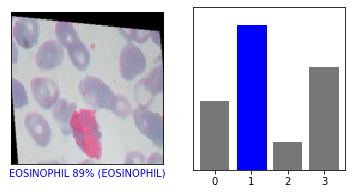

In [19]:
X_test1 = np.array(X_test).reshape(-1,128, 128, 3)
i = 124
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test1)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

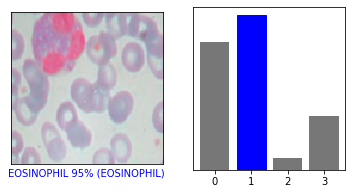

In [20]:
#predictions from the predictions dataset
X_pred1 = np.array(X_pred).reshape(-1,128, 128, 3)
i = 7
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, prediction_pred[i], y_pred, X_pred1)
plt.subplot(1,2,2)
plot_value_array(i, prediction_pred[i],  y_pred)
plt.show()

In [25]:
pred_results = []
for i in range(len(prediction_pred)):
    result = np.argmax(prediction_pred[i])
    pred_results.append(result)

from sklearn.metrics import classification_report
from sklearn import metrics

print(metrics.confusion_matrix(y_pred,pred_results ))
print(metrics.classification_report(y_pred,pred_results, digits=4))

[[28 20  0  0]
 [ 0 13  0  0]
 [ 3  0  1  0]
 [ 0  0  0  6]]
              precision    recall  f1-score   support

           0     0.9032    0.5833    0.7089        48
           1     0.3939    1.0000    0.5652        13
           2     1.0000    0.2500    0.4000         4
           3     1.0000    1.0000    1.0000         6

    accuracy                         0.6761        71
   macro avg     0.8243    0.7083    0.6685        71
weighted avg     0.8236    0.6761    0.6898        71



In [2]:
#prediction sample data
DIR = r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\blood-cells\dataset2-master\dataset2-master\images\TEST_SIMPLE"

In [3]:
def create_data(DATADIR):
    training_data = []
    for category in CATEGORIES:
        print(category)
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array =cv2.imread(path+ '/' + img)
            img_file = scipy.misc.imresize(arr=img_array, size=(128, 128, 3))
            training_data.append([img_file, class_num])
        print(len(training_data))
    return training_data

In [45]:
import random
import scipy.misc
data_pred = create_data(DIR)

random.shuffle(data_pred)

NEUTROPHIL
48
EOSINOPHIL
61
MONOCYTE
65
LYMPHOCYTE
71


C:\Users\arifm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


In [46]:
# capital X for feature set # feature set has to be numpy array
X_pred = []
#y is your training set
y_pred = []
for features, label in data_pred:
    X_pred.append(features)
    y_pred.append(label)

In [48]:
X_pred = np.array(X_pred)

X_pred = X_pred.astype('float32') / 255

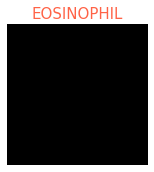

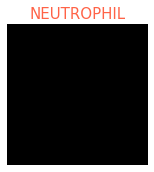

In [10]:
for k in range(2):
    plt.figure(figsize=(25,15))
    plt.subplot(5, 5,2)
    plt.yticks([])
    plt.xticks([])
    category = CATEGORIES[y_pred[k]]
    plt.title(category, color='tomato').set_size(15)
    plt.axis('off')
    image = X_pred[k]
    image = image[:, :, [2, 1, 0]] 
    plt.imshow(image)

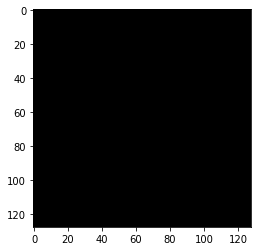

EOSINOPHIL
71
(71, 128, 128, 3)


In [9]:
i =25
plt.imshow(X_pred[i])
plt.show()
print(CATEGORIES[y_pred[i]])
print(len(X_pred))
print(X_pred.shape)

In [55]:
#saving the data for further use
import pickle

#pickle is like json data is serilised for python
pickle_out = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\X_pred.pickle","wb")
pickle.dump(X_pred, pickle_out)
pickle_out.close()

pickle_out = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\y_pred.pickle","wb")
pickle.dump(y_pred, pickle_out)
pickle_out.close()